In [1]:
# import glob
# import math
import sys, os
sys.path.append('..')
sys.path.append('.')

import os.path
import shutil
import subprocess

import tensorflow as tf
import ddsp
import ddsp.colab.colab_utils
import IPython
import matplotlib.pyplot as plt
import numpy as np
# import scipy.fft
import scipy.io
# import scipy.signal

/juno/u/jyau/anaconda3/envs/regnet/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
data_dir = 'data/hammer'
source_files = ['ceramic.wav', 'polycarb.wav', 'steel.wav', 'wood.wav']
clips = []
forces = []
for f in source_files:
    fs, clip = scipy.io.wavfile.read(os.path.join(data_dir, f))
    offset = 0.15
    length = 3.0
    clip = clip[int(fs*offset):int(fs*(offset+length)), :]
    force = clip[:, 1]
    clip = clip[:, 0]
#     sos = scipy.signal.butter(10, 50, 'hp', fs=fs, output='sos')
#     clip = scipy.signal.sosfiltfilt(sos, clip)
    # Normalize
    clip = clip - np.mean(clip)
    clip = clip / np.max(np.abs(clip))
    clips.append(clip)
    forces.append(force)
clips = np.array(clips, dtype=np.float32)
forces = np.array(forces, dtype=np.float32)
# Sample first recording
IPython.display.Audio(data=clips[0, :], rate=fs)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Initialize modules, with internal sampling rate 2x the original recording sample rate
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(fs*sample_factor/1.0), sample_rate=int(fs*sample_factor),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(fs*sample_factor), n_samples=int(clip.shape[0]*sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

In [5]:
# Initialize all variables to optimize
tf.random.set_seed(0)
# Impact profile variables
# Discretize time into frame rate of 100 for impact predictions
discretization_frame_rate = 100
abbrev_length = int(discretization_frame_rate * (clips.shape[1]/fs))
mags = tf.Variable(tf.zeros((clips.shape[0], abbrev_length, 1)), dtype=tf.float32)
stdevs = tf.Variable(0.1 * tf.ones((clips.shape[0], abbrev_length, 1)), dtype=tf.float32)
taus = tf.Variable(tf.zeros((clips.shape[0], abbrev_length, 1)), dtype=tf.float32)

# Time-constant noise variables
noise_magnitudes = tf.Variable(tf.zeros((clips.shape[0], 200), dtype=tf.float32))

# Modal FIR variables
num_frequencies = 256
frequencies = tf.Variable(tf.random.normal((clips.shape[0], 1, num_frequencies,)), dtype=tf.float32)
dampings = tf.Variable(tf.random.normal((clips.shape[0], 1, num_frequencies,)), dtype=tf.float32)
gains = tf.Variable(tf.random.normal((clips.shape[0], 1, num_frequencies,)), dtype=tf.float32)

# Reverb variables
reverb_gains = tf.Variable(-1.0 + tf.zeros((clips.shape[0], 1, 32)), dtype=tf.float32)
reverb_decay = tf.Variable(3.0 + tf.zeros((clips.shape[0], 1, 32)), dtype=tf.float32)

# Acceleration sound variables
acceleration_scale = tf.Variable(0.2 * tf.ones((clips.shape[0], 1)), dtype=tf.float32, constraint=tf.keras.constraints.NonNeg())

# Optimization step counter
step_count = 0

In [6]:
# Setup loss and optimizer
loss = ddsp.losses.SpectralLoss(loss_type='L1', mag_weight=1.0, logmag_weight=1.0,
                               fft_sizes=(2048, 1024, 512, 256))

def generate_audio():
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse
    impc = impact.get_controls(mags, stdevs, taus, 0)
    impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    # Generate modal FIR
    irc = modal_fir.get_controls(gains, frequencies, dampings)
    ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])
    # Convolve together for modal vibration sounds
    audio = ddsp.core.fft_convolve(impulse_profile, ir)
    
    # Generate and add time constant noise
    unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    
    # Add reverb
    revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc['ir'])
    
    # Downsample from internal sampling rate to original recording sampling rate
    audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    return audio

def loss_func():
    """Compute spectral loss from current audio estimate."""
    audio = generate_audio()
    return loss.call(tf.stop_gradient(clips), audio)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

In [7]:
num_iters = 10000
check_interval = 50
for i in range(num_iters):
    if i % check_interval == 0:
        print('Step\t%i:\t%0.3f'%(step_count, loss_func()))
    opt.minimize(loss_func, var_list=[noise_magnitudes, frequencies, dampings, gains, taus, mags, stdevs, acceleration_scale])
    step_count += 1
print('Step\t%i:\t%0.3f'%(step_count, loss_func()))

Step	0:	6.546
Step	50:	6.288
Step	100:	6.047
Step	150:	5.807
Step	200:	5.656
Step	250:	5.508
Step	300:	5.377
Step	350:	5.267
Step	400:	5.179
Step	450:	5.119
Step	500:	5.024
Step	550:	4.963
Step	600:	4.916
Step	650:	4.850
Step	700:	4.805
Step	750:	4.739
Step	800:	4.691
Step	850:	4.649
Step	900:	4.609
Step	950:	4.576
Step	1000:	4.533
Step	1050:	4.480
Step	1100:	4.437
Step	1150:	4.398
Step	1200:	4.359
Step	1250:	4.312
Step	1300:	4.280
Step	1350:	4.233
Step	1400:	4.213
Step	1450:	4.188
Step	1500:	4.152
Step	1550:	4.133
Step	1600:	4.116
Step	1650:	4.085
Step	1700:	4.074
Step	1750:	4.049
Step	1800:	4.041
Step	1850:	4.023
Step	1900:	4.004
Step	1950:	3.988
Step	2000:	3.962
Step	2050:	3.951
Step	2100:	3.943
Step	2150:	3.917
Step	2200:	3.904
Step	2250:	3.891
Step	2300:	3.884
Step	2350:	3.868
Step	2400:	3.849
Step	2450:	3.836
Step	2500:	3.823
Step	2550:	3.812
Step	2600:	3.805
Step	2650:	3.791
Step	2700:	3.779
Step	2750:	3.771
Step	2800:	3.759
Step	2850:	3.752
Step	2900:	3.751
Step	2950:	3.743
Ste

In [8]:
# Generate impulse responses
irc = modal_fir.get_controls(gains, frequencies, dampings)
ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])
# Sample first impulse response
IPython.display.Audio(data=ir[0, :], rate=fs*sample_factor)

In [9]:
audio = generate_audio()
# Sample first generated audio clip
IPython.display.Audio(data=audio[2, :], rate=fs)

In [11]:
save_results = True
load_results = False
output_dir = 'output/abs'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

def save_audio(audio, output_prefix):
    for i in range(audio.shape[0]):
        filename = os.path.join(output_dir, '%s%s'%(output_prefix, source_files[i]))
        scipy.io.wavfile.write(filename, fs, np.array(32767 * audio[i, :] / np.max(np.abs(audio))).astype(np.int16))
if save_results:
    synth_audio = generate_audio()
    impc = impact.get_controls(mags, stdevs, taus, 0)
    synth_forces = impact.get_signal(impc['magnitudes'], impc['taus'])
    save_audio(clips, 'real-')
    save_audio(audio, 'synth-')
    np.save(os.path.join(output_dir, 'synth-audio.npy'), synth_audio)
    np.save(os.path.join(output_dir, 'real-audio.npy'), clips)
    np.save(os.path.join(output_dir, 'synth-forces.npy'), synth_forces)
    np.save(os.path.join(output_dir, 'real-forces.npy'), forces)
if load_results:
    synth_audio = np.load(os.path.join(output_dir, 'synth-audio.npy'))
    real_audio = np.load(os.path.join(output_dir, 'real-audio.npy'))
    synth_forces = np.load(os.path.join(output_dir, 'synth-forces.npy'))
    real_forces = np.load(os.path.join(output_dir, 'real-forces.npy'))
else:
    synth_audio = generate_audio()
    impc = impact.get_controls(mags, stdevs, taus, 0)
    synth_forces = impact.get_signal(impc['magnitudes'], impc['taus'])
    real_audio = clips
    real_forces = forces
# Sample first generated audio clip
IPython.display.Audio(data=synth_audio[0, :], rate=fs)

In [12]:
# Plotting code
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 30
plt.rcParams['font.size'] = font_size
fig_width = 10
fig_height = 3
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    """Plots a spectrogram."""
    if len(audio.shape) == 2:
        audio = audio[0, :]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    if rotate:
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(audio.shape[0]) / fs
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, audio.shape[0] / fs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    xtick_locs = (xtick_nums / audio.shape[0] / fs * logmag.shape[1]).astype(np.int32)
    xtick_nums = xtick_locs / logmag.shape[1] * audio.shape[0] / fs
    plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Real 'ceramic'


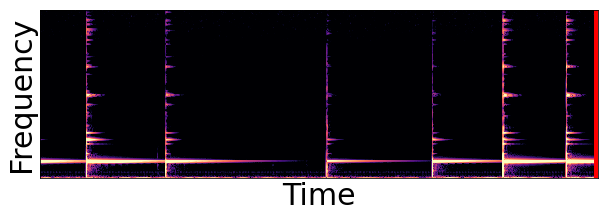

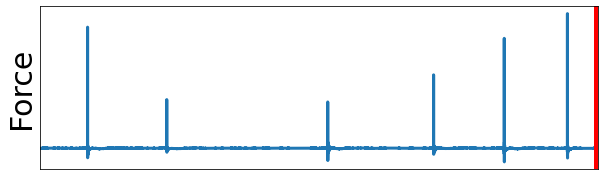

Synthesized 'ceramic'


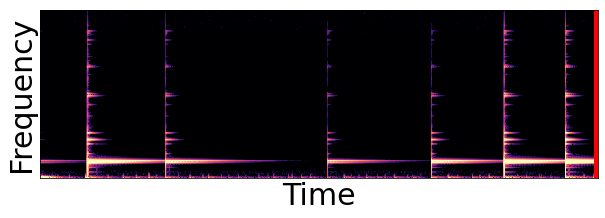

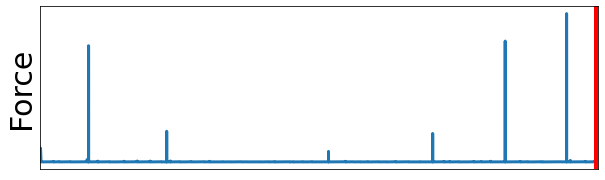

Real 'polycarb'


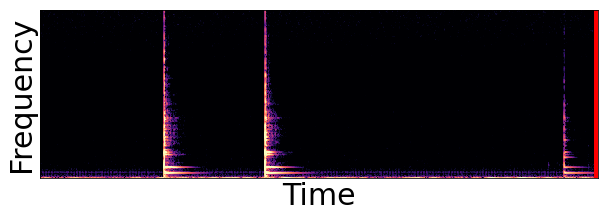

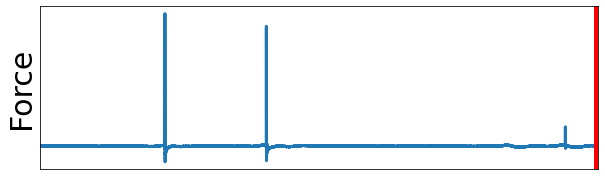

Synthesized 'polycarb'


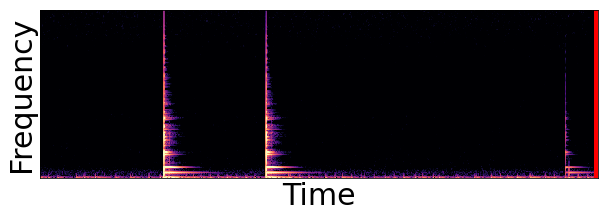

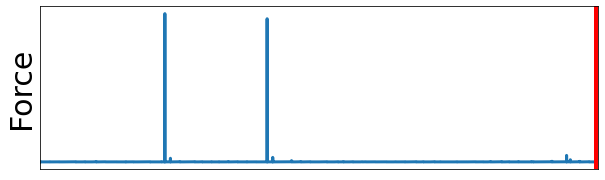

Real 'steel'


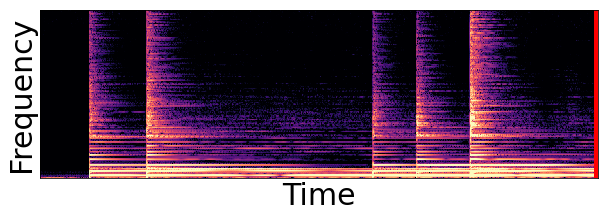

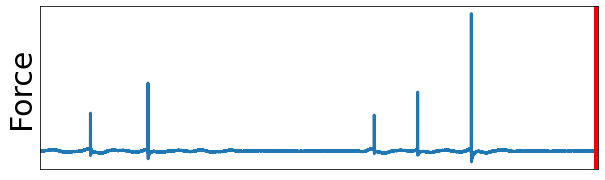

Synthesized 'steel'


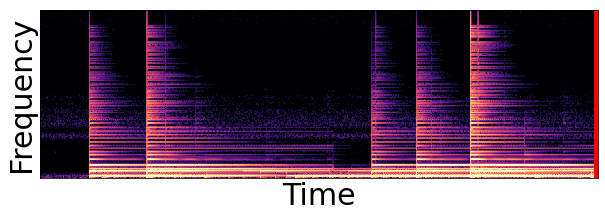

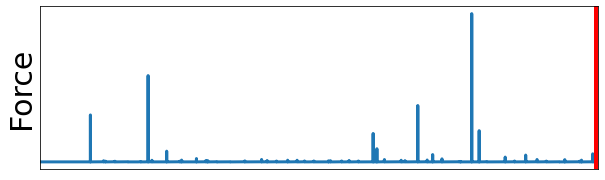

Real 'wood'


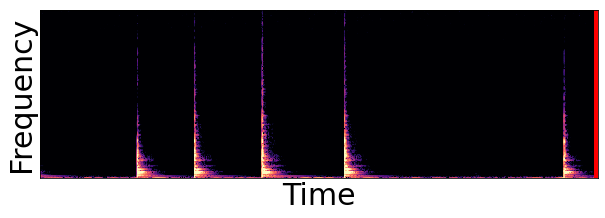

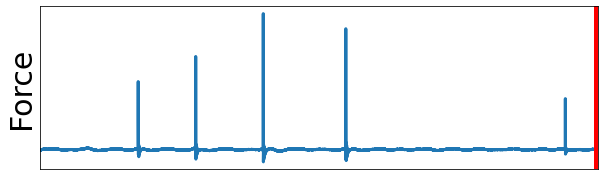

Synthesized 'wood'


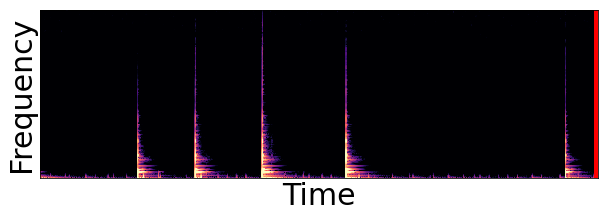

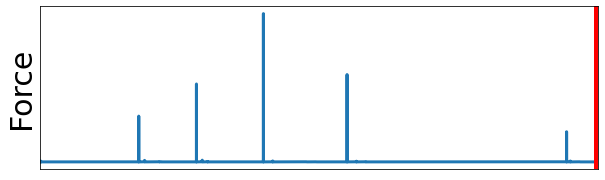

In [14]:
# Plot and animate spectrograms and impact force profiles for each recording
frame_rate = 60
figure_dir = os.path.join(output_dir, 'figures')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)
temp_dir = os.path.join(figure_dir, 'temp-images')
def clip_plots(in_clip, in_forces, prefix, xlabel, animate=False):
    num_seconds = in_clip.shape[0] / fs
    ddsp.colab.colab_utils.specplot(in_clip, size=512)
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)
    if not xlabel:
        plt.xlabel(' ')
    filename = os.path.join(figure_dir, '%s-spec'%prefix)
    fig.savefig('%s.png'%filename, bbox_inches='tight')
    if animate:
        os.mkdir(temp_dir)
        ax = plt.gca()
        line = ax.axvline(-0.5, lw=8, color='red')
        ylims = plt.ylim()
        xlims = plt.xlim()
        
        for i in range(int(num_seconds * frame_rate)):
            x_pos = xlims[0] + (i / (frame_rate * num_seconds - 1) * (xlims[1] - xlims[0]))
            line.set_data([x_pos, x_pos], ylims)
            fig.savefig(os.path.join(temp_dir, 'image%03i.png'%i), bbox_inches='tight')
        subprocess.check_output("ffmpeg -r %i -i %s.png -vcodec mpeg4 -y %s.mp4"%
                  (frame_rate, os.path.join(temp_dir,'image%03d'), filename), shell=True)
        shutil.rmtree(temp_dir)
        
    plt.show()
    
    plt.plot(in_forces / np.max(in_forces), linewidth=3)
    plt.ylabel('Force')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, in_forces.shape[0])
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)
    filename = os.path.join(figure_dir, '%s-force'%prefix)
    fig.savefig('%s.png'%filename, bbox_inches='tight')
    if animate:
        os.mkdir(temp_dir)
        ax = plt.gca()
        line = ax.axvline(-0.5, lw=8, color='red')
        ylims = plt.ylim()
        xlims = plt.xlim()
        
        for i in range(int(num_seconds * frame_rate)):
            x_pos = xlims[0] + (i / (frame_rate * num_seconds - 1) * (xlims[1] - xlims[0]))
            line.set_data([x_pos, x_pos], ylims)
            fig.savefig(os.path.join(temp_dir, 'image%03i.png'%i), bbox_inches='tight')
        subprocess.check_output("ffmpeg -r %i -i %s.png -vcodec mpeg4 -y %s.mp4"%
                  (frame_rate, os.path.join(temp_dir,'image%03d'), filename), shell=True)
        shutil.rmtree(temp_dir)
    plt.show()

for i in range(clips.shape[0]):
    print('Real \'%s\''%os.path.splitext(source_files[i])[0])
    clip_plots(real_audio[i, :], real_forces[i, :], 'real-%s'%os.path.splitext(source_files[i])[0], xlabel=True, animate=True)
    print('Synthesized \'%s\''%os.path.splitext(source_files[i])[0])
    clip_plots(synth_audio[i, :], synth_forces[i, :], 'synth-%s'%os.path.splitext(source_files[i])[0], xlabel=True, animate=True)